[View in Colaboratory](https://colab.research.google.com/github/kimjungwon90/DeepFin-Series-JPMorgan/blob/master/FakeNews2.ipynb)

# Recurrent Neural Nets - Fake News

The RNN (LSTM) architechture that we are using is shown below, a many to one RNN.

![RNNs](https://github.com/sachinruk/deepschool.io/blob/master/images/RNN-unrolled.png?raw=true)

<img src='https://media.giphy.com/media/l0Iyau7QcKtKUYIda/giphy.gif'>

We achieve 87% accuracy in a test set. However, the article in Second reference claims to have 93% accuracy. The main difference is that they seem to use a Bag of Words Model, which loses the order of words when sending into the ML algorithm. Also

## References:
1. Data: https://github.com/GeorgeMcIntire/fake_real_news_dataset
2. Classification using Scikit Learn: https://blog.kjamistan.com/comparing-scikit-learn-text-classifiers-on-a-fake-news-dataset/
3. Glove vectors: https://nlp.stanford.edu/projects/glove/



In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/fZ2VS-Okju8?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

from sklearn.model_selection import train_test_split

from collections import Counter

Using TensorFlow backend.


In [2]:
!wget https://github.com/GeorgeMcIntire/fake_real_news_dataset/raw/master/fake_or_real_news.csv.zip
!unzip fake_or_real_news.csv.zip

--2018-06-25 01:35:57--  https://github.com/GeorgeMcIntire/fake_real_news_dataset/raw/master/fake_or_real_news.csv.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GeorgeMcIntire/fake_real_news_dataset/master/fake_or_real_news.csv.zip [following]
--2018-06-25 01:35:57--  https://raw.githubusercontent.com/GeorgeMcIntire/fake_real_news_dataset/master/fake_or_real_news.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11878108 (11M) [application/zip]
Saving to: ‘fake_or_real_news.csv.zip’

fake_or_real_news.c 100%[===================>]  11.33M  --.-KB/s    in 0.08s   

2018-

Preprocessing steps: lower case, remove urls, some punctuations etc.

In [4]:
df = pd.read_csv('fake_or_real_news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
df.drop(['Unnamed: 0', 'title'], axis=1, inplace=True)

df.text = df.text.str.lower()
df.text = df.text.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.text = df.text.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.text = df.text.str.replace(r'\.',' . ') #replace multple periods with a single one
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.text = df.text.str.strip() 
print(df.shape)
df.head()

(6335, 3)


,title,text,label
0,you can smell hillarys fear,daniel greenfield a shillman journalism fellow...,FAKE
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,FAKE
2,kerry to go to paris in gesture of sympathy,u . s . secretary of state john f . kerry said...,REAL
3,bernie supporters on twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 the les...,FAKE
4,the battle of new york why this primary matters,its primary day in new york and frontrunners h...,REAL


In [6]:
all_text = ' '.join(df.text.values)
words = all_text.split()
u_words = Counter(words).most_common()
len(u_words)

86806

In [7]:
len(words)

5145738

In [8]:
u_words = [word[0] for word in u_words if word[1]>20]
len(u_words)

12488

Get all the unique words. We will only consider words that have been used more than 5 times. Finally from this we create a dictionary mapping words to integers.

Once this is done we will create a list of reviews where the words are converted to ints.

In [9]:
# # create the dictionary
word2num = dict(zip(u_words,range(len(u_words))))
word2num['<Other>'] = len(word2num)
num2word = dict(zip(word2num.values(), word2num.keys()))

int_text = [[word2num[word] if word in word2num else word2num['<Other>'] 
             for word in content.split()] for content in df.text.values]

print('The number of unique words are: ', len(u_words))
print('The first review looks like this: ')
print(int_text[0][:20])
print('And once this is converted back to words, it looks like: ')
print(' '.join([num2word[i] for i in int_text[0][:20]]))
print(df.text.values[0][:100])

The number of unique words are:  12488
The first review looks like this: 
[4482, 12488, 5, 12488, 2872, 1229, 24, 0, 573, 483, 8, 5, 56, 243, 2529, 2873, 10, 1455, 1644, 1]
And once this is converted back to words, it looks like: 
daniel <Other> a <Other> journalism fellow at the freedom center is a new york writer focusing on radical islam .
daniel greenfield a shillman journalism fellow at the freedom center is a new york writer focusing o


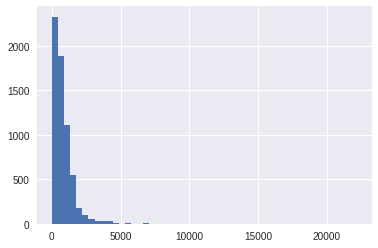

In [10]:
plt.hist([len(t) for t in int_text],50)
plt.show()

In [11]:
print('The number of articles greater than 500 in length is: ', np.sum(np.array([len(t)>500 for t in int_text])))
print('The number of articles less than 50 in length is: ', np.sum(np.array([len(t)<50 for t in int_text])))

The number of articles greater than 500 in length is:  3714
The number of articles less than 50 in length is:  440


You cannot pass differing lengths of sentences to the algorithm. Hence we shall prepad the sentence with `<PAD>`. Sequences less than 500 in length will be prepadded and sequences that are longer than 500 will be truncated. It is assumed that the sentiment of the review can be asserted from the first 500 words.

In [12]:
num2word[len(word2num)] = '<PAD>'
word2num['<PAD>'] = len(word2num)

for i, t in enumerate(int_text):
    if len(t)<500:
        int_text[i] = [word2num['<PAD>']]*(500-len(t)) + t
    elif len(t)>500:
        int_text[i] = t[:500]
    else:
        continue

x = np.array(int_text)
y = (df.label.values=='REAL').astype('int')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

A real news article:

In [13]:
df[df.label=='REAL'].text.values[0][:200]

'u . s . secretary of state john f . kerry said monday that he will stop in paris later this week amid criticism that no top american officials attended sundays unity march against terrorism . kerry sa'

A fake news article:

In [14]:
df[df.label=='FAKE'].text.values[0][:200]

'daniel greenfield a shillman journalism fellow at the freedom center is a new york writer focusing on radical islam . in the final stretch of the election hillary rodham clinton has gone to war with t'

## Many to One LSTM

### Basic Method:
This method is no different to the method utilised in the sentiment analysis lesson.

In [15]:
model = Sequential()
model.add(Embedding(len(word2num), 50)) # , batch_size=batch_size
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          624500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 654,005
Trainable params: 654,005
Non-trainable params: 0
_________________________________________________________________


In [16]:
batch_size = 128
epochs = 5
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Train on 5701 samples, validate on 634 samples
Epoch 1/5
5701/5701 [==============================] - 57s 10ms/step - loss: 0.6302 - acc: 0.6611 - val_loss: 0.3881 - val_acc: 0.8691
Epoch 2/5
5701/5701 [==============================] - 56s 10ms/step - loss: 0.5359 - acc: 0.7607 - val_loss: 0.4040 - val_acc: 0.8849
Epoch 3/5
5701/5701 [==============================] - 56s 10ms/step - loss: 0.3365 - acc: 0.8821 - val_loss: 0.3021 - val_acc: 0.9022
Epoch 4/5
5701/5701 [==============================] - 56s 10ms/step - loss: 0.3167 - acc: 0.8942 - val_loss: 0.3113 - val_acc: 0.8912
Epoch 5/5
5701/5701 [==============================] - 56s 10ms/step - loss: 0.2154 - acc: 0.9270 - val_loss: 0.3644 - val_acc: 0.8533


In [17]:
sentence = "North korea is testing out missiles on americans living overseas .".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

array([[0.22129942]], dtype=float32)

In [18]:
' '.join([num2word[w] for w in sentence_num])[-200:]

'> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> north korea is testing out missiles on americans living overseas .'

In [19]:
sentence = "The chemicals in the water is turning the freaking frogs gay says cnn . ".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

array([[0.5411863]], dtype=float32)

In [20]:
' '.join([num2word[w] for w in sentence_num])[-200:]

'> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> the chemicals in the water is turning the <Other> <Other> gay says cnn .'

In [21]:
sentence = "President Trump is the greatest president of all time period .".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(0) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

array([[0.625706]], dtype=float32)

In [22]:
' '.join([num2word[w] for w in sentence_num])[-200:]

'president trump is the greatest president of all time period .'

In [23]:
model.evaluate(X_test, y_test)

634/634 [==============================] - 6s 10ms/step


[0.3644016094576297, 0.8533123034031985]

In [24]:
final_embeddings = model.get_weights()[0]

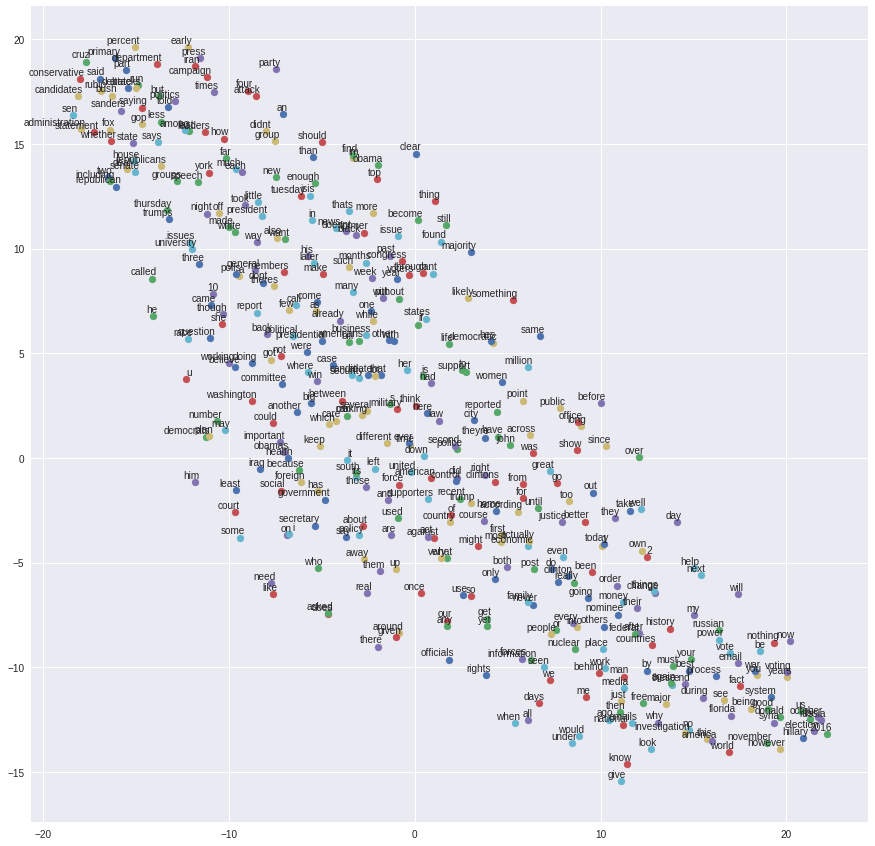

In [28]:
from sklearn.manifold import TSNE
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    plt.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    plt.show()

words = [num2word[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)
